In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from survival import DecayMIRModel
from survival import MIRModel
from survival.age_group_extension import AgeSurvivalModel
from survival.three_parameter_log_form import LogFormMIRModel

## INPUT DATA

### [GBD 2019 MIRs with GBD 2019 background mortality]

In [2]:
#PROCESS INPUTS
df = pd.read_csv('/home/j/temp/fed1/2019_mirs_with_background_mortality_ca_only.csv')
#df = pd.read_csv('/home/j/temp/fed1/2019_mirs_with_background_mortality_ca_only_cap_background_mortality.csv')

#remove NAs and MIR >1
df = df.dropna()
df = df[df['mi_ratio']<=1]
df = df[df['age_group_id']!=22]
df = df[df['age_group_id']!=28]
df = df[df['age_group_id']!=2]
df = df[df['age_group_id']!=3]
df = df[df['age_group_id']!=4]
df = df[df['age_group_id']!=5]

df.head()

,Unnamed: 0,Unnamed: 0.1,location_id,year_id,sex_id,age_group_id,acause,mi_ratio,life_table_parameter_id,background_mortality
0,19817280,19817281,527,1980,1,1,neo_bladder,0.072146,3.0,0.015537
1,19817281,19817282,527,1980,1,1,neo_brain,0.311148,3.0,0.015537
2,19817282,19817283,527,1980,1,1,neo_breast,0.071203,3.0,0.015537
3,19817283,19817284,527,1980,1,1,neo_colorectal,0.269248,3.0,0.015537
4,19817284,19817285,527,1980,1,1,neo_esophageal,0.667472,3.0,0.015537


## I. Base MIR -> Survival Model:

#### [M/I = (1-P_s^n)(P_c)/(P_c+P_o)]

In [ ]:
#PARAMETERS
num_years = 5
disease_pd = 10

#RUN BASE MODEL
model = MIRModel(df['mi_ratio'],
                 df['background_mortality'],
                 disease_period=disease_pd)
model.compute_excess_mortality()
survival_rate = model.get_survival_rate(num_years=num_years)

# SAVE IN ORIGINAL DATA FRAME
df['excess_mortality_og_mir_model'] = model.excess_mortality
df['abs_survival_rate_og_mir_model'] = survival_rate['abs']
df['rel_survival_rate_og_mir_model'] = survival_rate['rel']

## IV. Three parameter decay model:

#### [log(P_c) = b*log(1+exp(-(x-a)))+c]

In [3]:
# PARAMETERS
parameters = pd.read_csv('/homes/fed1/Survival_Franny/three_parameter_log_form_values_SEER_6_9_2021_with_acause.csv')
df = df.merge(parameters, how="left", on=['acause'])

# Fix CLL to be all cause parameters because fit is wonky
df.loc[df['acause']=="neo_leukemia_ll_chronic",'a']=5.1355100
df.loc[df['acause']=="neo_leukemia_ll_chronic",'b']=0.65851832

num_years = 5

# RUN THREE PARAMETER LOG MODEL
three_param_model = LogFormMIRModel(df['mi_ratio'],
                                    df['background_mortality'],
                                    df['a'],
                                    df['b'])
three_param_model.compute_third_parameter()
survival_rate = three_param_model.get_survival_rate(num_years=num_years)

# SAVE IN ORIGINAL DATA FRAME
df['predicted_c'] = three_param_model.c
df['abs_survival_rate_three_param_model'] = survival_rate['abs']
df['rel_survival_rate_three_param_model'] = survival_rate['rel']

## Comparison to 1-MIR Methods

In [4]:
df['rel_survival_old_gbd_model'] = 1-df['mi_ratio']

## Comparison to SEER Data for 5 year relative survival

In [5]:
# SEER CALIFORNIA SURVIVAL 2000-2016
SEER = pd.read_csv("/homes/fed1/Survival_Franny/SEER_CA_formatted_test_for_paper.csv")

# SUBSET
SEER = SEER[SEER['year_id']==0] # All years 2000-2016
SEER = SEER.drop(columns=['year_id','cause','num_years'])

# MERGE INTO MAIN DATA FRAME
df = df.merge(SEER, how="left", on=['age_group_id','sex_id','acause'])

## Prediction Scatters

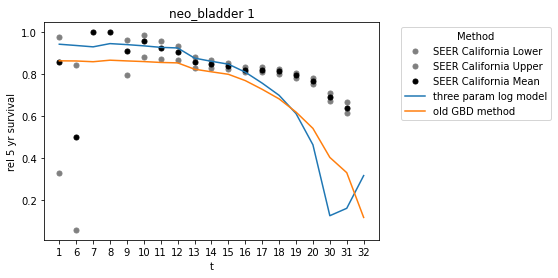

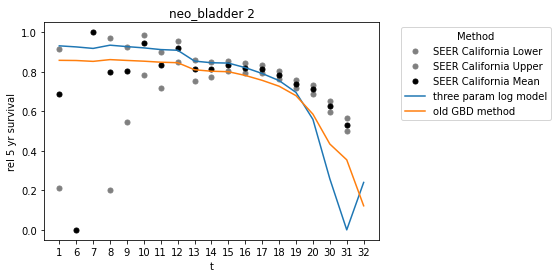

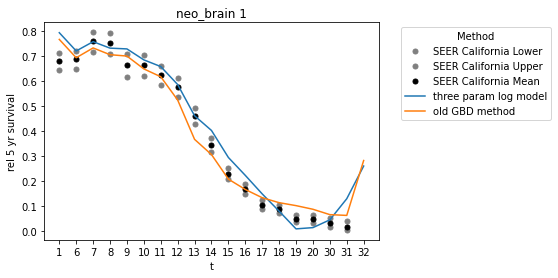

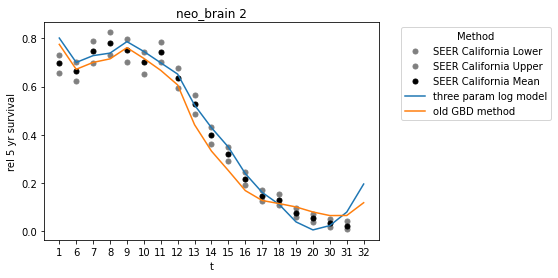

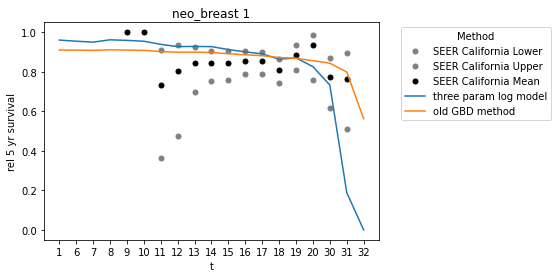

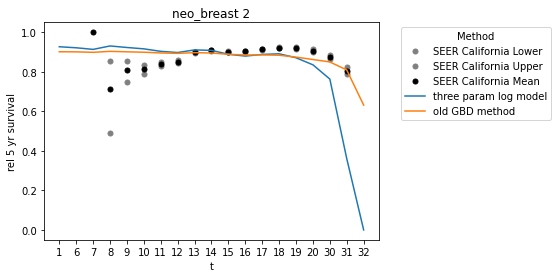

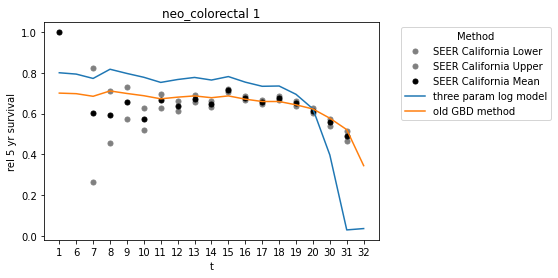

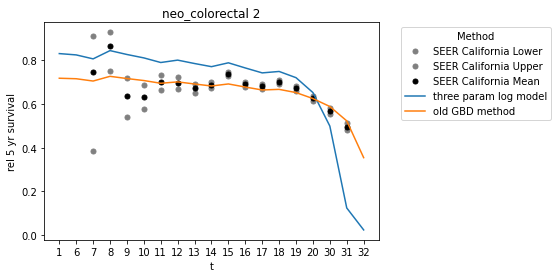

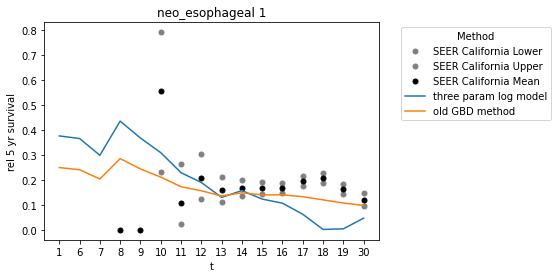

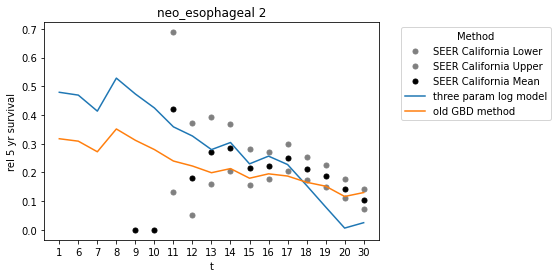

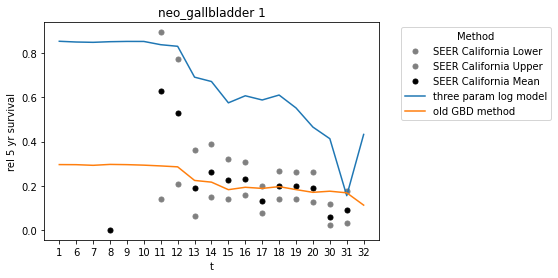

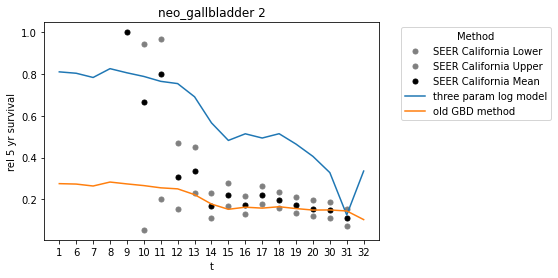

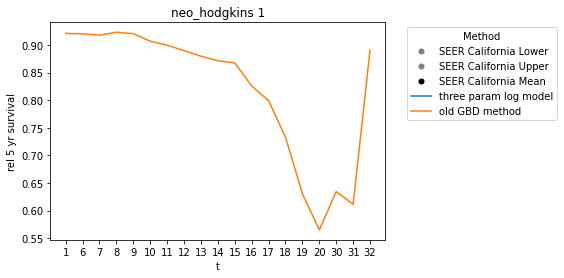

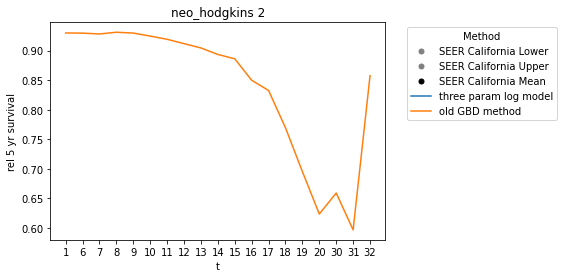

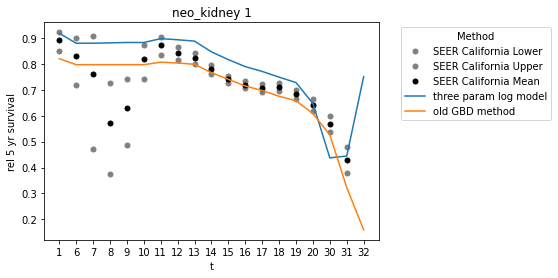

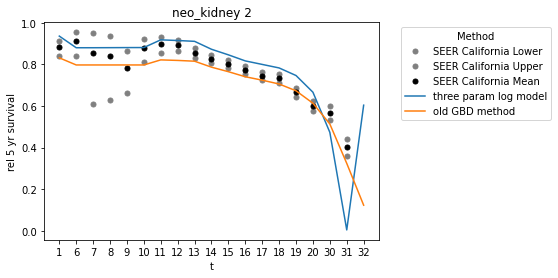

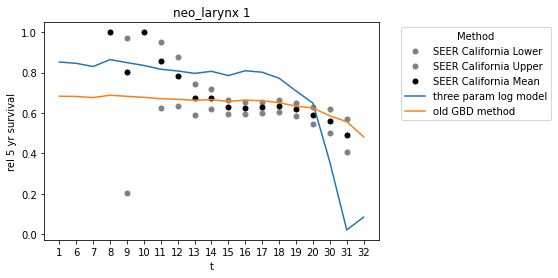

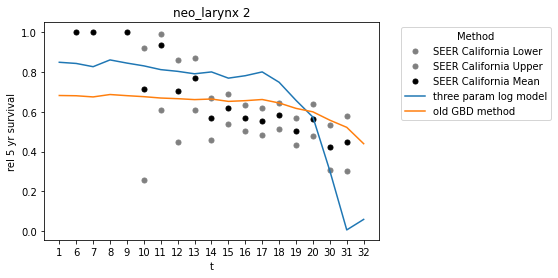

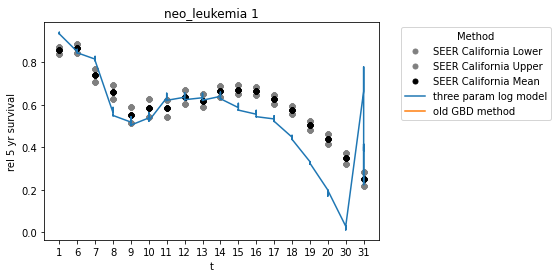

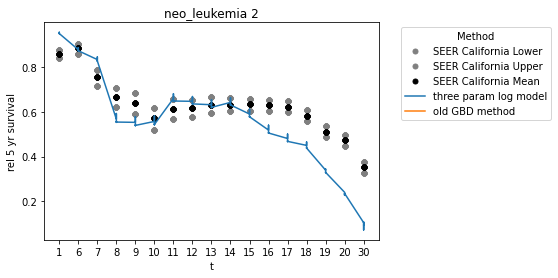

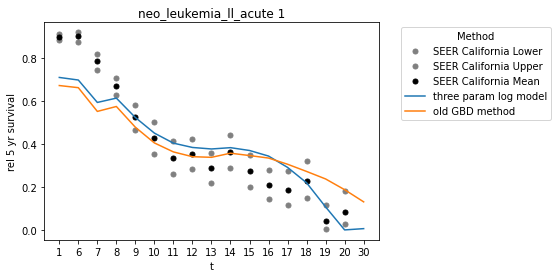

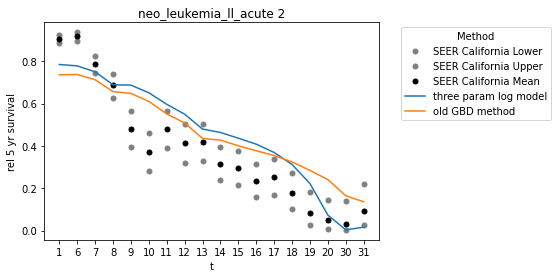

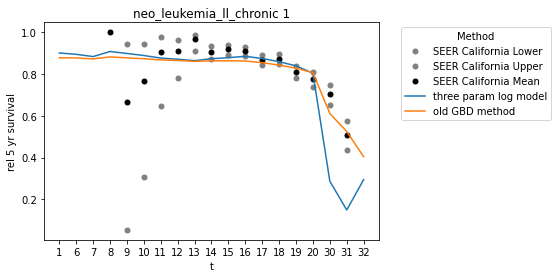

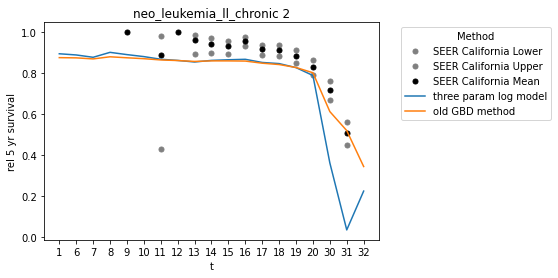

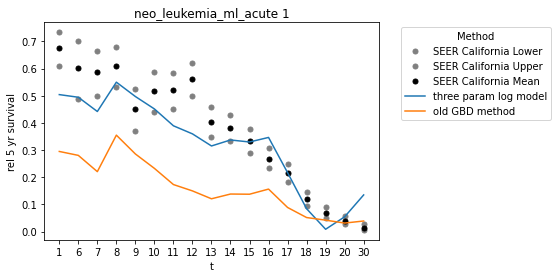

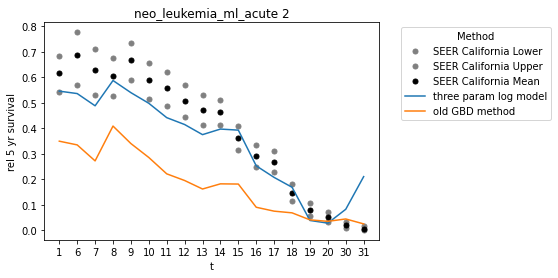

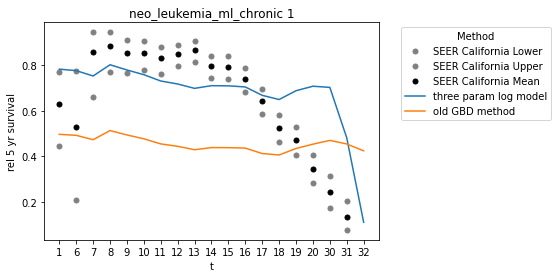

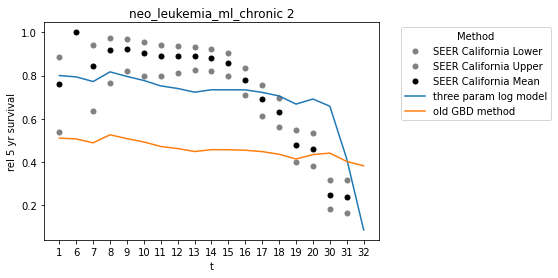

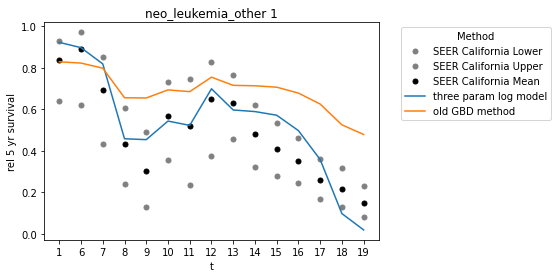

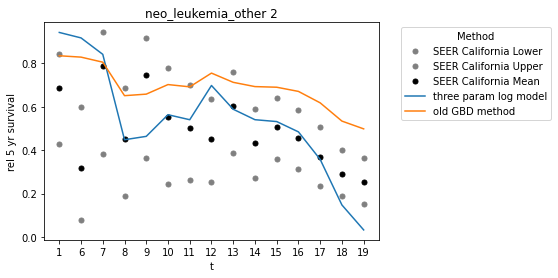

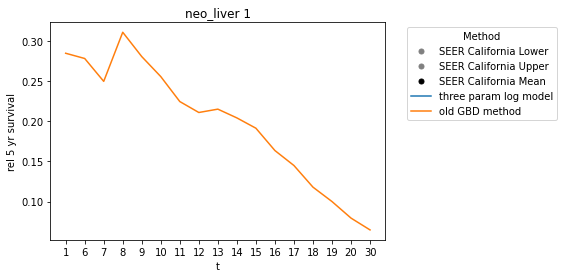

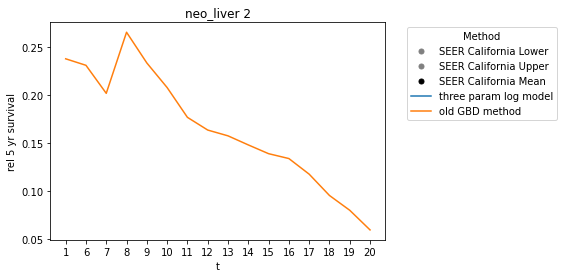

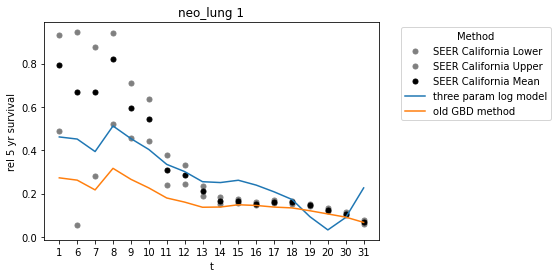

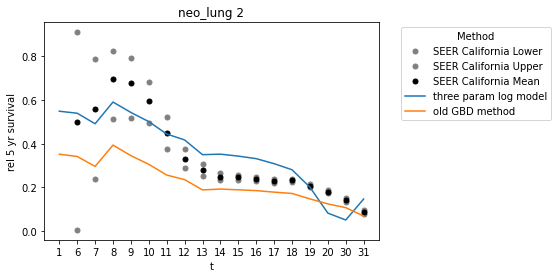

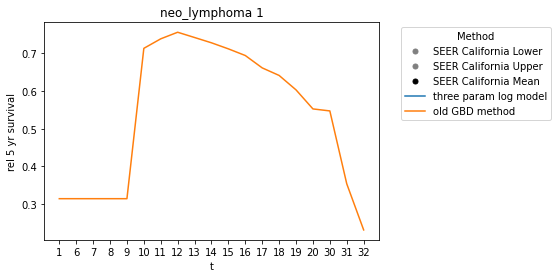

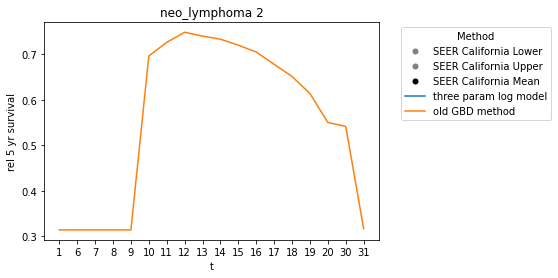

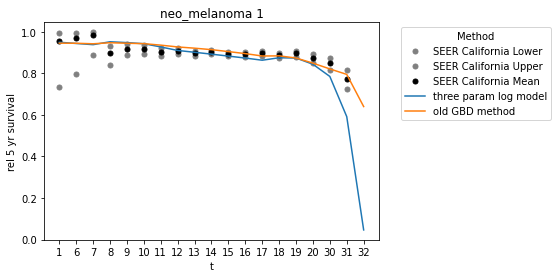

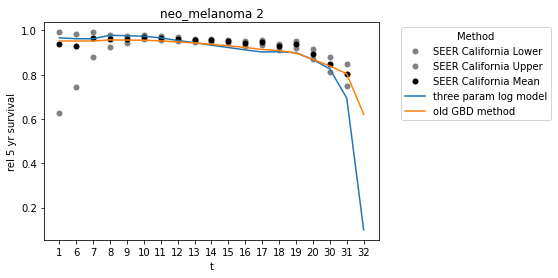

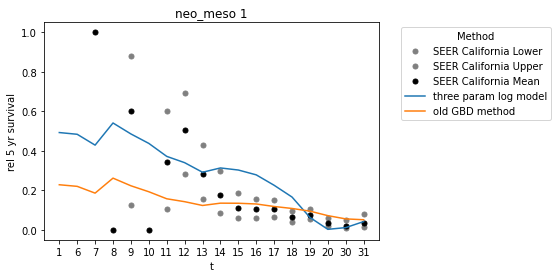

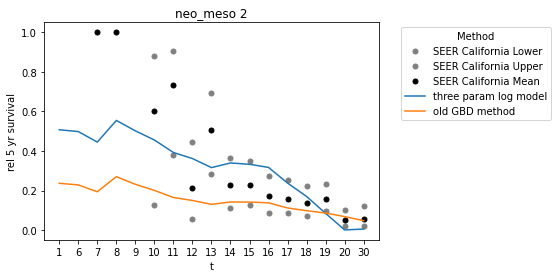

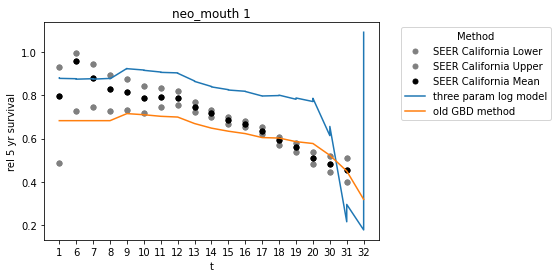

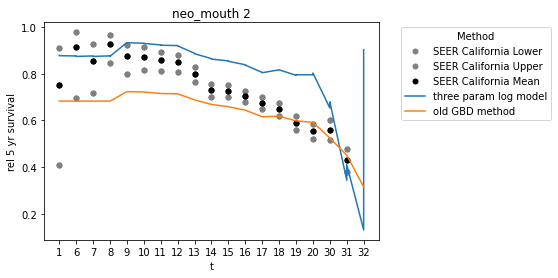

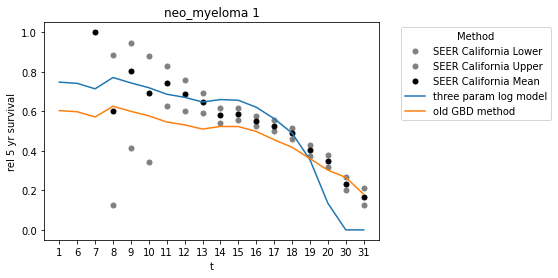

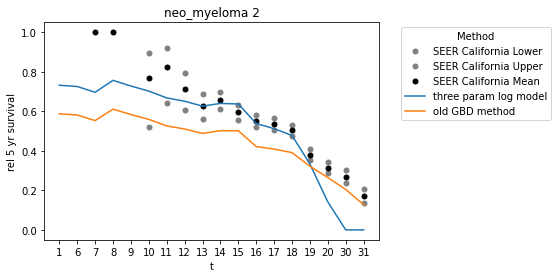

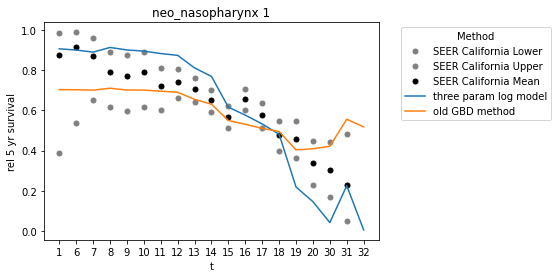

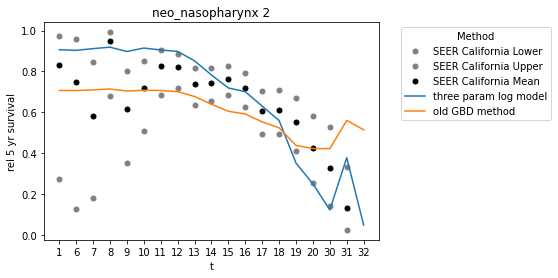

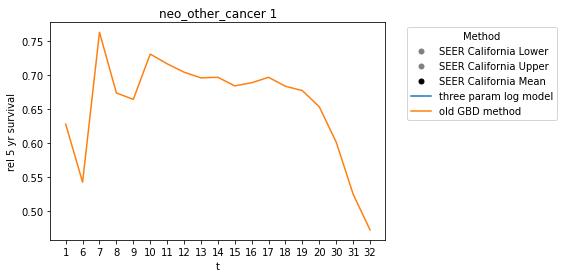

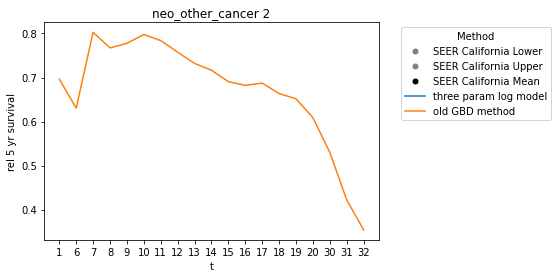

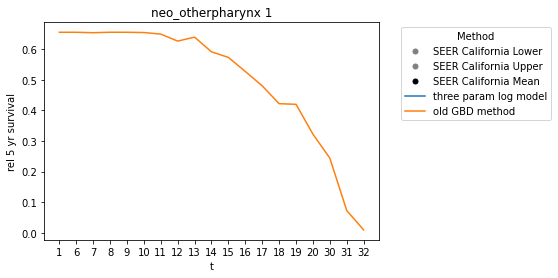

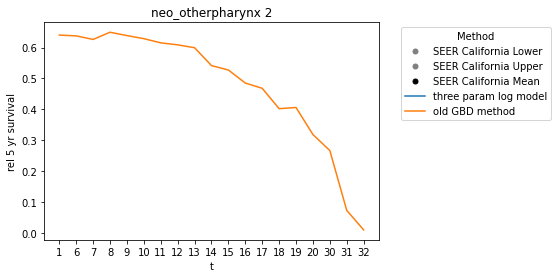

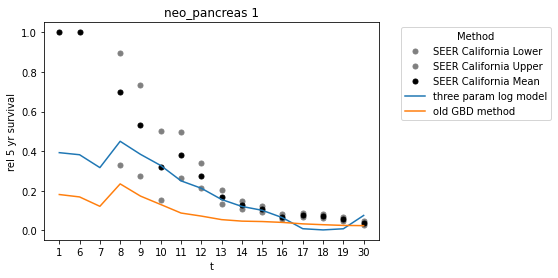

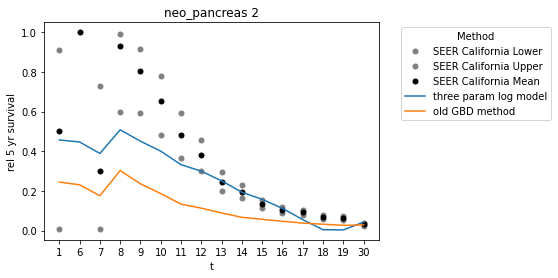

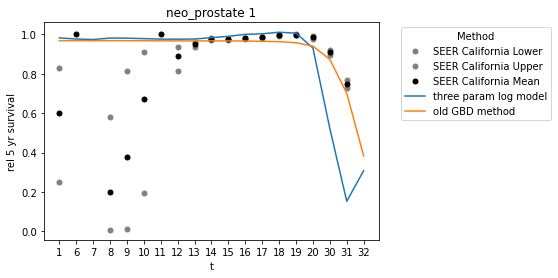

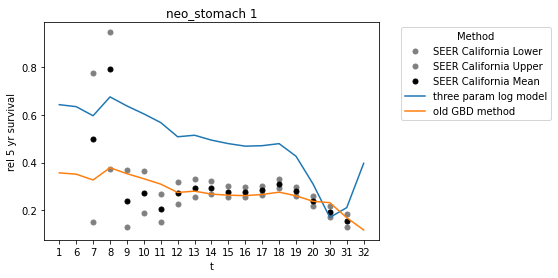

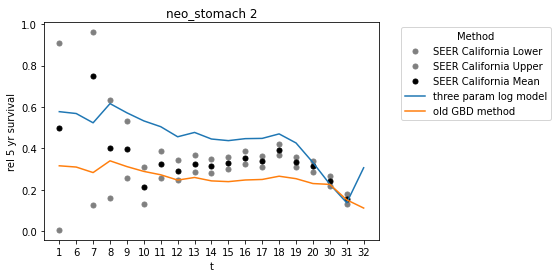

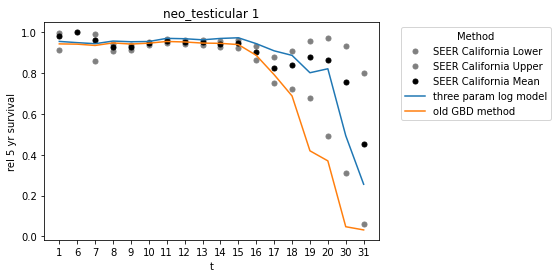

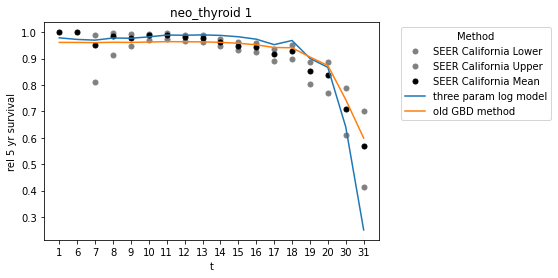

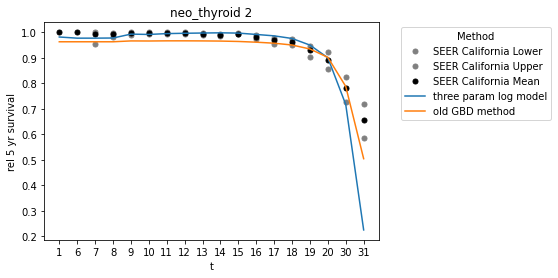

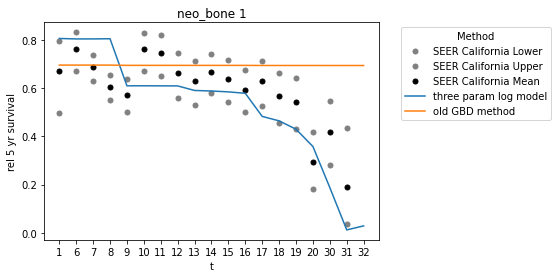

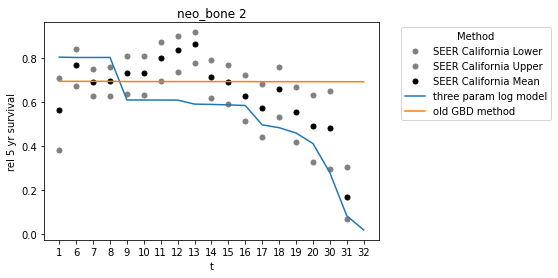

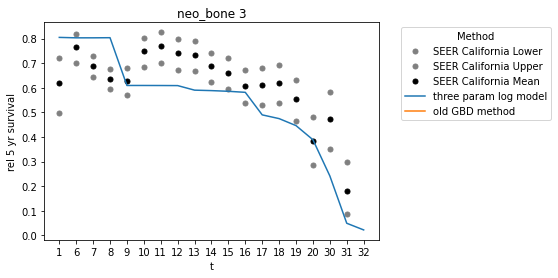

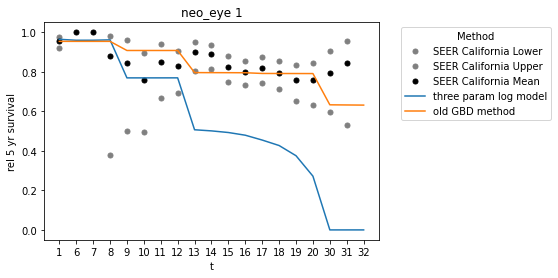

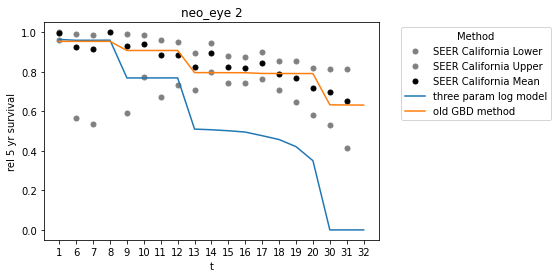

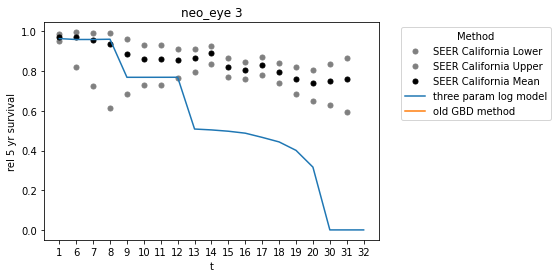

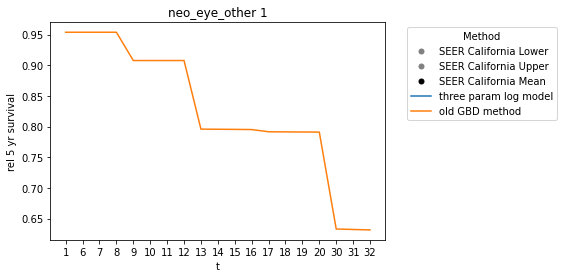

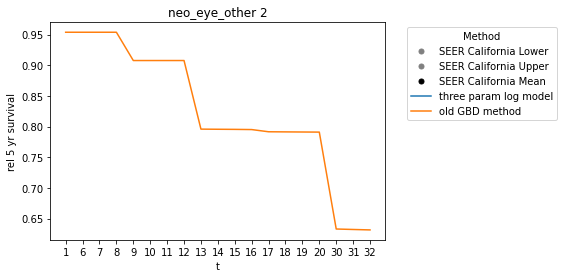

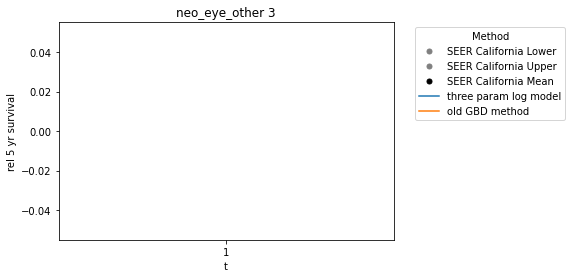

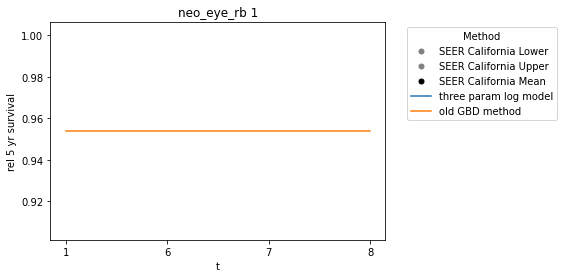

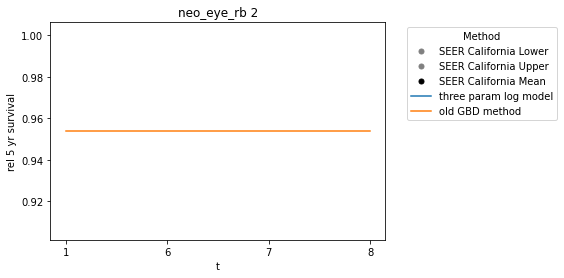

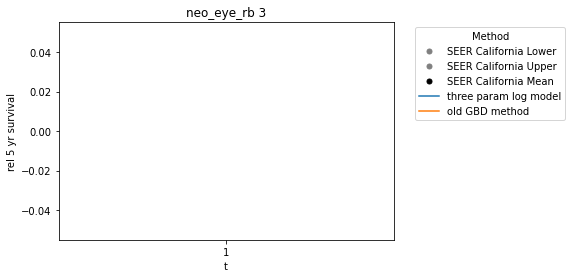

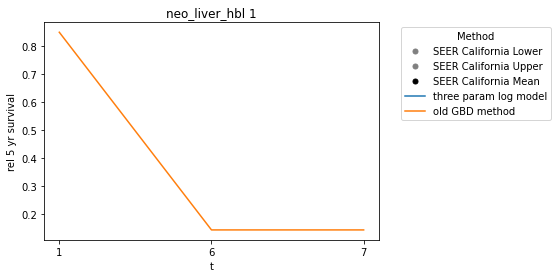

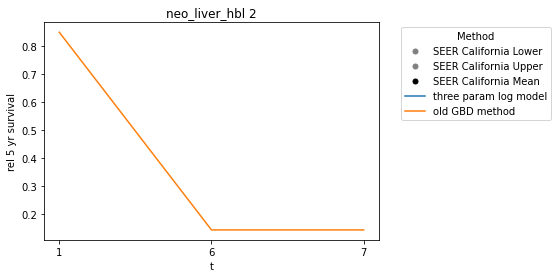

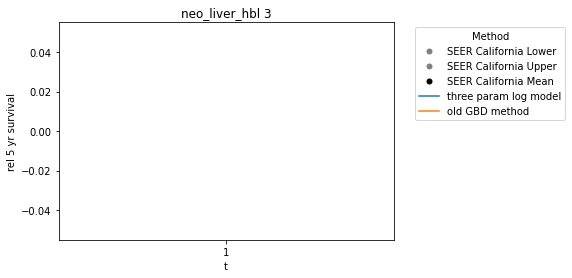

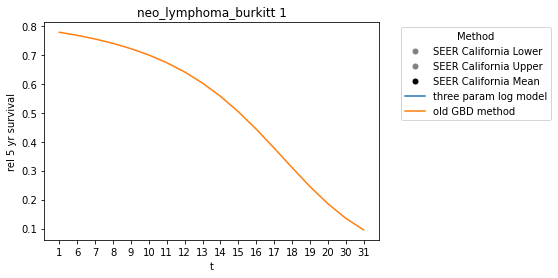

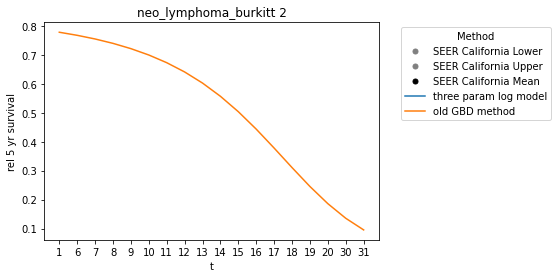

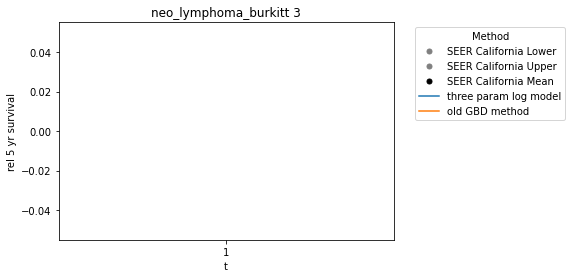

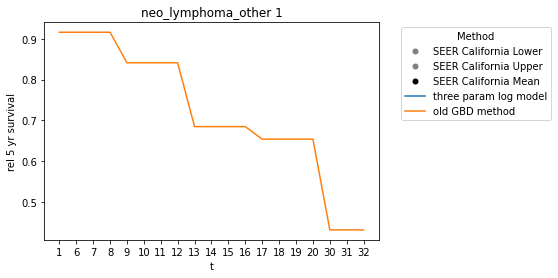

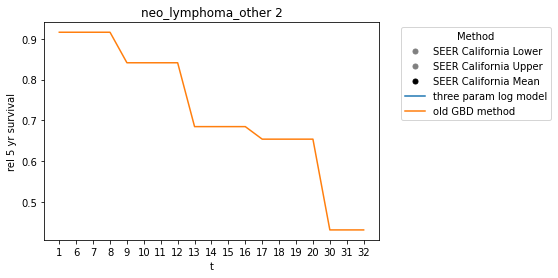

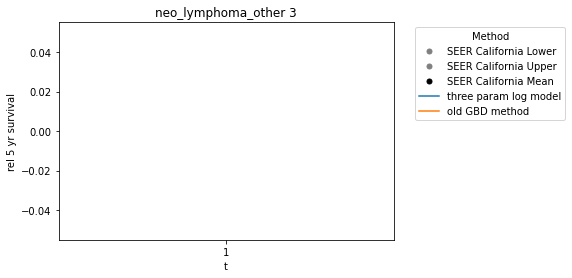

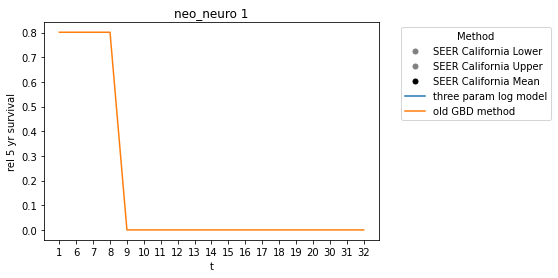

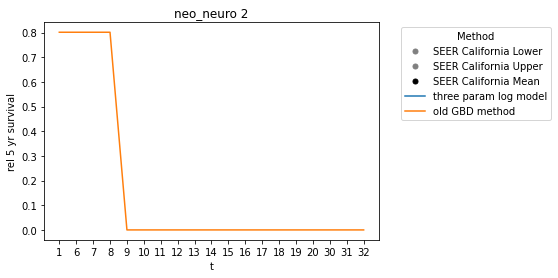

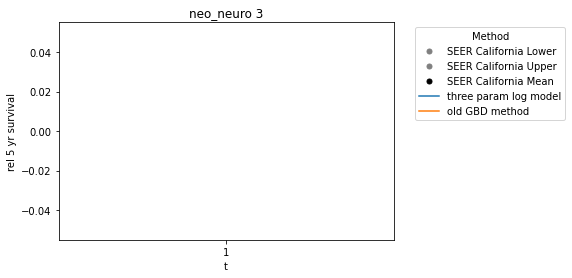

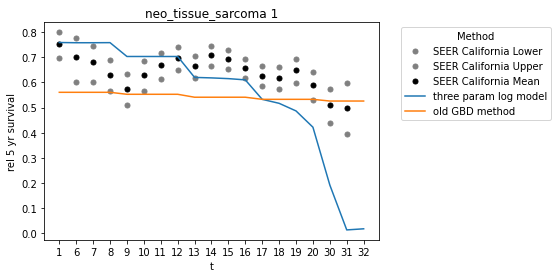

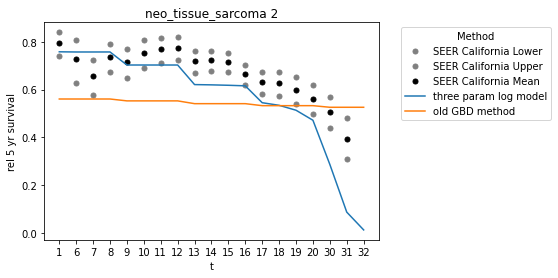

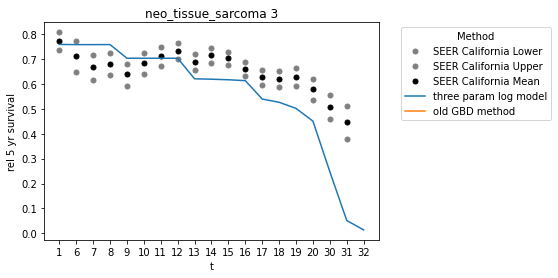

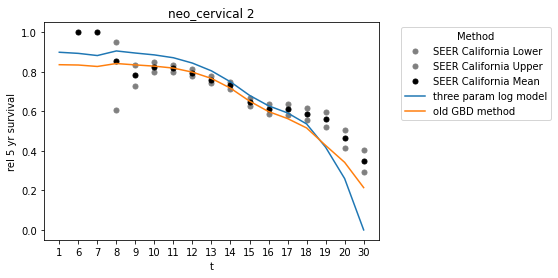

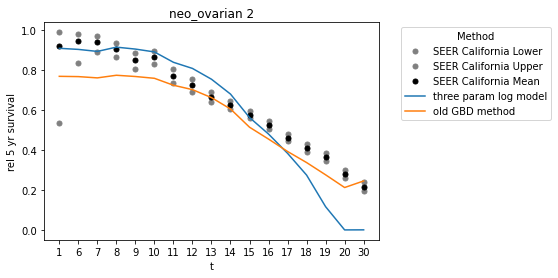

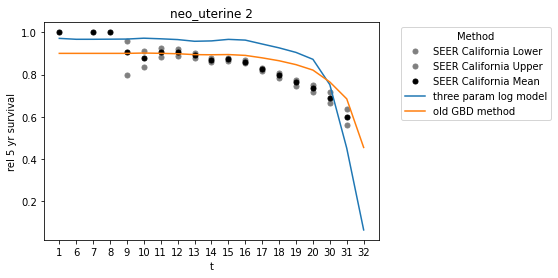

In [6]:
for cancer in df.acause.unique():
        
        cancer_data = df[df['acause']==cancer]
        cancer_data = cancer_data[cancer_data['year_id']==2010]
        
        for sex_name in cancer_data.sex.unique():

            data = cancer_data[cancer_data['sex_id']==sex]
            
            # PLOT
            t = list(map(str, data['age_group_id']))
            plt.plot(t, data['Rel_Lower'], 'o', color='0.5', markersize=5, label='SEER California Lower')
            plt.plot(t, data['Rel_Upper'], 'o', color='0.5', markersize=5, label='SEER California Upper')
            plt.plot(t, data['Relative'], 'o', color='0',markersize=5, label='SEER California Mean')
            #plt.plot(t, data['rel_survival_rate_og_mir_model'], '-', markersize=4, label='base model')
            plt.plot(t, data['rel_survival_rate_three_param_model'], '-', markersize=4, label='Proposed Model')
            plt.plot(t, data['rel_survival_old_gbd_model'], '-', markersize=4, label='1 - MIR')
            plt.xlabel("t")
            plt.ylabel("rel 5 yr survival")
            plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.title(cancer+" "+sex_name)
            plt.show()


In [ ]:
#df.to_csv('/home/j/temp/fed1/comparing_all_survival_methods_in_CA_6_9_2021.csv')